In [69]:
# load the locs per project
nosql_locs = {}
with open('/home/pablo/tesis/tsm-pipeline/experiments/datasets/nosql_1_locs.csv', 'r') as f:
    for l in f.readlines()[1:]:
        l = l.rstrip()
        db_name, locs = l.split(',')
        db_name = db_name.replace('/','_')
        nosql_locs[db_name] = int(locs)

In [76]:
import re
import datetime as dt
from collections import defaultdict
from dataclasses import dataclass
from typing import Optional

# main regex
ts_re = re.compile('\[\w+\t(?P<timestamp>.+)\].+\tdbname=(?P<dbname>[a-zA-Z0-9_\.-]+)\s(?P<msg>.+)$')
# parse timestamp regex
parse_ts = lambda ts: dt.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S,%f')


@dataclass
class Data:
    start_time: Optional[dt.datetime] = None
    end_time: Optional[dt.datetime] = None
    
    def pipeline_time(self):
        if self.start_time == None or self.end_time == None:
            return -1
        return (self.end_time - self.start_time) / dt.timedelta(milliseconds=1)

# main parse line func
def parse_line(l: str):
    ts_groups = ts_re.match(l).groupdict()
    return parse_ts(ts_groups['timestamp']), ts_groups['dbname'], ts_groups['msg']

def parse_logfile(contents: str):
    db_process_info = defaultdict(lambda: Data())
    for l in contents.splitlines():
        l = l.rstrip()
        try:
            ts, dbname, msg = parse_line(l)
        except:
            continue
        data = db_process_info[dbname]
        if msg == 'running pipeline':
            data.start_time = ts
        elif msg == 'run ok':
            data.end_time = ts
    cleaned_times = [
    (k, db.pipeline_time(), nosql_locs[k]) for k,db in db_process_info.items() if db.pipeline_time() > 0
    ]
    # sort by lcos
    cleaned_times.sort(key=lambda c: c[2])
    return cleaned_times

In [79]:
with open("/home/pablo/dev-results/nosql-perf-experiment-1/training_log.txt", 'r') as f:
    cleaned_times_1 = parse_logfile(f.read())
    
with open("/home/pablo/dev-results/nosql-perf-experiment-2/training_log.txt", 'r') as f:
    cleaned_times_2 = parse_logfile(f.read())
    
with open("/home/pablo/dev-results/nosql-perf-experiment-3/training_log.txt", 'r') as f:
    cleaned_times_3 = parse_logfile(f.read())

In [81]:
avg_cleaned_times = []
cleaned_times = [cleaned_times_1, cleaned_times_2, cleaned_times_3]
for i in range(len(cleaned_times_1)):
    dbname = cleaned_times_1[i][0]
    locs = cleaned_times_1[i][2]
    avg_time = 0
    for cl in cleaned_times:
        avg_time += cl[i][1]
    avg_time /= len(cleaned_times)
    avg_cleaned_times.append((dbname, avg_time, locs))

In [82]:
avg_cleaned_times

[('laurieroy_CampReview_3ee2945', 5397.0, 10922),
 ('MiloATH_VotingApp_94e125c', 6079.333333333333, 11352),
 ('18F_checklistomania_9865774', 6431.333333333333, 12068),
 ('Hadh_Cord-System-Photon_293d655', 5986.666666666667, 12944),
 ('DanWahlin_CustomerManager_8c42393', 6212.333333333333, 13506),
 ('mrvautin_adminMongo_9ab2e98', 89784.66666666667, 13777),
 ('amejiarosario_meanshop_305a189', 6348.0, 15224),
 ('MasseyHacks_MasseyHacks-IV-Quill_1c8fbcd', 6693.666666666667, 19480),
 ('processing_p5.js-web-editor_3357af6', 51451.333333333336, 24210),
 ('DanWahlin_CustomerManagerStandard_8918f51', 17318.666666666668, 25772),
 ('sahat_tvshow-tracker_083614d', 8143.0, 26027),
 ('cnodejs_nodeclub_5f50776', 20462.666666666668, 44589),
 ('krthr_felinorte_5f1514b', 29865.333333333332, 65905),
 ('ParabolInc_action_45c9b49', 19500.333333333332, 113898),
 ('meteor_meteor_a1caff0', 175562.66666666666, 203756)]

In [50]:
# matplotlib globals
# styling tips https://betterdatascience.com/top-3-matplotlib-tips/

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython import display
display.set_matplotlib_formats("svg")
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["xtick.labelsize"] = "medium"
plt.rcParams["ytick.labelsize"] = "medium"
plt.style.library['seaborn-paper']

/tmp/ipykernel_371739/1043866552.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")
/tmp/ipykernel_371739/1043866552.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.library['seaborn-paper']


RcParams({'axes.labelsize': 8.8,
          'axes.titlesize': 9.6,
          'figure.figsize': [6.4, 4.4],
          'grid.linewidth': 0.8,
          'legend.fontsize': 8.0,
          'lines.linewidth': 1.4,
          'lines.markeredgewidth': 0.0,
          'lines.markersize': 5.6,
          'patch.linewidth': 0.24,
          'xtick.labelsize': 8.0,
          'xtick.major.pad': 5.6,
          'xtick.major.width': 0.8,
          'xtick.minor.width': 0.4,
          'ytick.labelsize': 8.0,
          'ytick.major.pad': 5.6,
          'ytick.major.width': 0.8,
          'ytick.minor.width': 0.4})

<Axes: ylabel='runtime [millis]'>

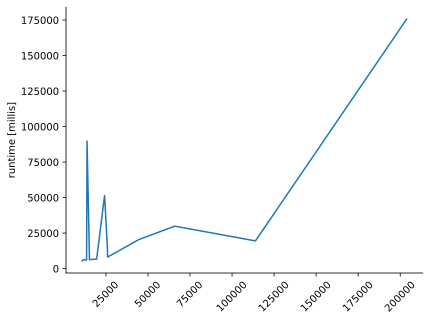

In [83]:
fig = plt.figure()
ax = fig.add_subplot()


ax.plot([c[2] for c in avg_cleaned_times], [c[1] for c in avg_cleaned_times], label='runtime per locs')

# ax.xaxis.set_major_locator(MultipleLocator(1000))

# rotate xticks
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_ylabel('runtime [millis]')
ax